In my Capstone project I analyse InstaCart Online Grocery Baskets. The main question that this project aims to address is how to optimize the product offerings of retailers by identifying customer behavior. By predicting if a customer has a healthy product basket based on the product names and clustering customers based on their product baskets, this project aims to provide insights into how retail should approach next best offer. The goal is to increase profits for retailers by better understanding and targeting the needs and preferences of their customers.


__Please note: this is notebook 3 of 5.__


In this notebook, the goal is to develop a machine learning model to accurately classify customers based on their consumer behavior patterns. By analyzing various patterns in customer behavior, we aim to identify important features that can help us predict the likelihood of a customer belonging to a particular category. I will use K-Means clustering model.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
%matplotlib inline

In [10]:
!pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
applaunchservices==0.2.1
appnope @ file:///opt/concourse/worker/volumes/live/0291c9e1-4b15-459f-623e-2770f55be269/volume/appnope_1594338395037/work
appscript @ file:///opt/concourse/worker/volumes/live/50ca4c96-3090-40bb-6981-3a6114ed0af4/volume/appscript_1594840187551/work
argh==0.26.2
asn1crypto @ file:///opt/concourse/worker/volumes/live/29c500db-6cdf-4cc7-7df8-fca74d6f0b64/volume/asn1crypto_1594339172552/work
astroid @ file:///opt/concourse/worker/volumes/live/21fd14a9-2a7e-484b-7394-5a9912cdcf80/volume/astroid_1592498459180/work
astropy==4.0.1.post1
atomicwrites==1.4.0
attrs==19.3.0
autopep8 @ file:///tmp/build/80754af9/autopep8_1592412889138/work
Babel==2.8.0
backcall==0.2.0
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/work
backports.shutil-get-terminal-size==1.0.0
backports.tempfile @ file:///home/linux1/recipes/ci/backports.tempfi

In [3]:
# download csv file I created in the Notebook1
df = pd.read_csv('/Users/evgenijkucukov/Desktop/Brainstation/Capstone/order_prodact_name_final')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,food,healthy,healthy_product_share,healthy_basket
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs,1,1,1.0,1
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs,1,1,1.0,1
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce,1,1,1.0,1
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce,1,1,1.0,1
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods,1,1,1.0,1


In [5]:
df['aisle'].nunique()

134

In [6]:
df['product_name'].nunique()

39123

We have 134 aisles (subcategories) of product and 39 123 product items. I will focus on aisles to identify general paterns.

I organized the data by grouping it according to order ID and user ID. For each order, I created a list of the aisles included. The resulting dataframe contains only one order per user, ensuring that both the order IDs and user IDs are unique.

In [8]:
df_basket = df.groupby(['order_id', 'user_id']).agg({'aisle': list})
df_basket

,,aisle
order_id,user_id,
1,112108,"[yogurt, other creams cheeses, fresh vegetable..."
36,79431,"[specialty cheeses, water seltzer sparkling wa..."
38,42756,"[nuts seeds dried fruit, packaged vegetables f..."
96,17227,"[lunch meat, fresh vegetables, packaged vegeta..."
98,56463,"[water seltzer sparkling water, refrigerated, ..."
...,...,...
3421049,189544,"[frozen breads doughs, breakfast bakery, energ..."
3421056,83898,"[yogurt, frozen meals, water seltzer sparkling..."
3421058,136952,"[specialty cheeses, packaged poultry, frozen p..."


In [9]:
# create dataframe
df_basket = df_basket.reset_index()
df_basket.head()

,order_id,user_id,aisle
0,1,112108,"[yogurt, other creams cheeses, fresh vegetable..."
1,36,79431,"[specialty cheeses, water seltzer sparkling wa..."
2,38,42756,"[nuts seeds dried fruit, packaged vegetables f..."
3,96,17227,"[lunch meat, fresh vegetables, packaged vegeta..."
4,98,56463,"[water seltzer sparkling water, refrigerated, ..."


In [10]:
# convert lists in string 
df_basket['aisle'] = df_basket['aisle'].apply(lambda x: ' , '.join(x))
df_basket.head()

,order_id,user_id,aisle
0,1,112108,"yogurt , other creams cheeses , fresh vegetabl..."
1,36,79431,"specialty cheeses , water seltzer sparkling wa..."
2,38,42756,"nuts seeds dried fruit , packaged vegetables f..."
3,96,17227,"lunch meat , fresh vegetables , packaged veget..."
4,98,56463,"water seltzer sparkling water , refrigerated ,..."


I vectorize aisles' names using Bag of Words. I want to calculate how many products of each aisle are in every product basket and create the sparse matrix.

In [11]:
# vectorize each product basket

from sklearn.feature_extraction.text import CountVectorizer
# 1. Instantiate 
bagofwords = CountVectorizer(tokenizer= lambda x: x.split(' , '))

# 2. Fit 
bagofwords.fit(df_basket['aisle'])

# 3. Transform
product_basket_transformed = bagofwords.transform(df_basket['aisle'])
product_basket_transformed

/Users/evgenijkucukov/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<131209x134 sparse matrix of type '<class 'numpy.int64'>'
	with 990769 stored elements in Compressed Sparse Row format>

In [12]:
# these are now the features, they are the individual tokens
bagofwords.get_feature_names()

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce',
 'canned jarred vegetables',
 'canned meals beans',
 'canned meat seafood',
 'cat food care',
 'cereal',
 'chips pretzels',
 'cleaning products',
 'cocoa drink mixes',
 'coffee',
 'cold flu allergy',
 'condiments',
 'cookies cakes',
 'crackers',
 'cream',
 'deodorants',
 'diapers wipes',
 'digestion',
 'dish detergents',
 'dog food care',
 'doughs gelatins bake mixes',
 'dry pasta',
 'eggs',
 'energy granola bars',
 'energy sports drinks',
 'eye ear care',
 'facial care',
 'feminine care',
 'first aid',
 'food storage',
 'fresh dips tapenades',
 'fresh fruits',
 'f

In [13]:
# converting the sparse matrix into a numpy array
product_basket_transformed.toarray()

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# create dataframe
my_product_basket = pd.DataFrame(columns=bagofwords.get_feature_names(), data=product_basket_transformed.toarray())
display(my_product_basket)

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
131206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


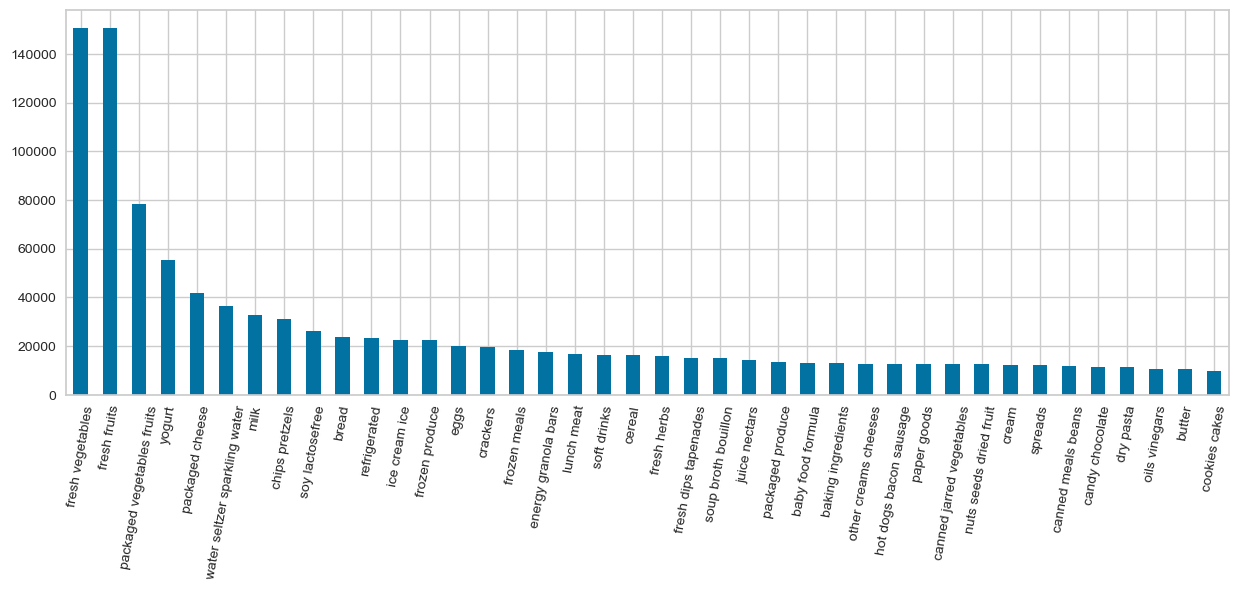

In [15]:
# create a visual with the most frequently occurred words

word_counts = pd.DataFrame(
    {"counts": product_basket_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(40).plot(kind="bar", figsize=(15, 5), legend=False)
plt.xticks(rotation=80)
plt.show()

Top 5 the most occured aisles are:
 - fresh vegetables
 - fresh fruits
 - packaged vagetables fruits
 - yogurt
 - packaged cheese

In clustering models we do not have target variables. So lets definy only X variables for further modeling.

In [16]:
# define X as a whole table after vectorizing
X = my_product_basket

Lets scale data first.

In [17]:
# apply scaling

from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Lets use PCA to reduce number of features.

In [18]:
# PCA import statement
from sklearn.decomposition import PCA

# Instantiate & fit PCA model 
my_PCA = PCA()
my_PCA.fit(X)

# transform data 
X_PCA = my_PCA.transform(X)

In [19]:
# check the percentage of variance explained by each component
my_PCA.explained_variance_ratio_

array([2.39854372e-01, 9.02725283e-02, 5.06073651e-02, 3.80637914e-02,
       3.02225545e-02, 2.77154860e-02, 2.51595588e-02, 2.10647053e-02,
       1.99279093e-02, 1.72375962e-02, 1.67064754e-02, 1.57286996e-02,
       1.51254873e-02, 1.37171272e-02, 1.23334825e-02, 1.17220460e-02,
       1.10231989e-02, 1.04046745e-02, 1.02856873e-02, 9.98046188e-03,
       9.66943365e-03, 9.30737711e-03, 8.66753838e-03, 8.49311340e-03,
       8.18265777e-03, 8.05713788e-03, 7.89522888e-03, 7.41858822e-03,
       7.28854565e-03, 7.19312096e-03, 6.98607022e-03, 6.73431122e-03,
       6.67831263e-03, 6.31294815e-03, 6.14037072e-03, 6.10271834e-03,
       6.00789880e-03, 5.87941107e-03, 5.77998775e-03, 5.65343787e-03,
       5.52310972e-03, 5.23560944e-03, 5.18498107e-03, 5.05716598e-03,
       4.86688070e-03, 4.71462647e-03, 4.61007659e-03, 4.54771613e-03,
       4.44718246e-03, 4.40660277e-03, 4.36108742e-03, 4.18918079e-03,
       4.04092886e-03, 3.93933882e-03, 3.71099670e-03, 3.63909304e-03,
      

In [20]:
expl_var = my_PCA.explained_variance_ratio_

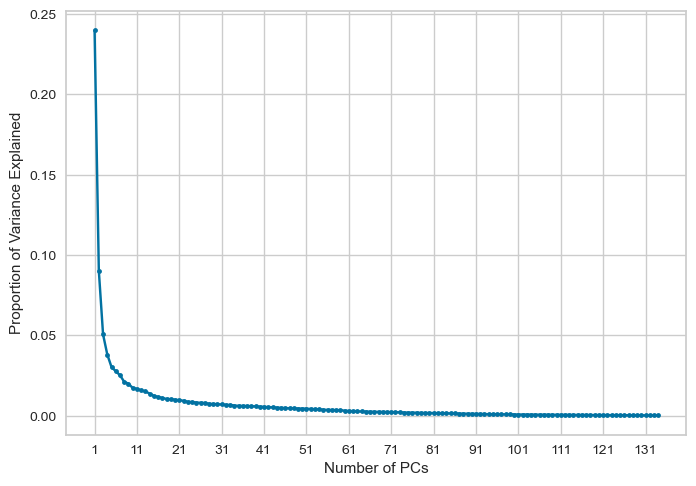

In [21]:
# make a line plot of the explained variance_ratio_ attribute

plt.figure()
plt.plot(range(1,135),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,135,10))
plt.show()

We can see that after 21 PCs, the amount of additional variance provided by subsequent PCs becomes very small. So the value of additional PCs diminishes. 21 PCs seems an appropriate number of principal components to move forward with.

In [22]:
# apply PCA with the optimum number of components

pca = PCA(n_components=21)
pca_data = pca.fit_transform(X_scaled)

## K-Means

Lets plot the distortion score to identify optimum number of clusters.
The distortion score is a measure of the compactness of the clusters, where lower values indicate tighter clusters with smaller within-cluster distances. A lower distortion score indicates a better clustering result. We will find  best number of clusters using elbow method.

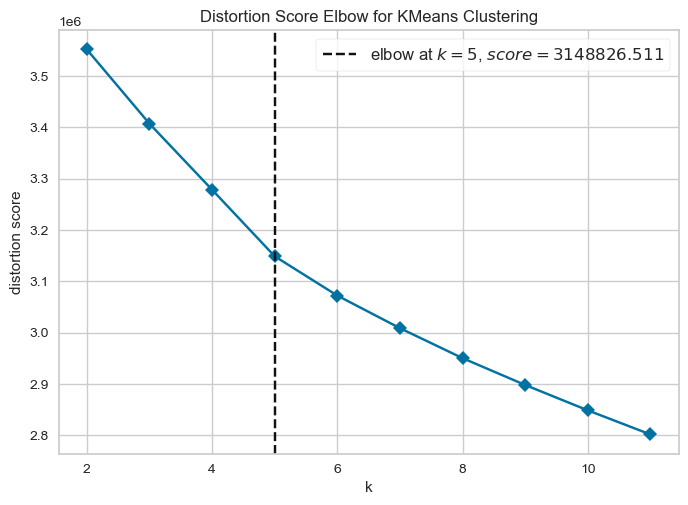

In [23]:
# yellowbrick visualization functions
from yellowbrick.cluster import silhouette_visualizer, kelbow_visualizer, intercluster_distance

# k-means clustering
from sklearn.cluster import KMeans

kelbow_visualizer(KMeans(random_state=1), pca_data, k=(2,12), timings=False);

The optimum number of clusters is 5. Lets check the silhouette score with this number of clusters.

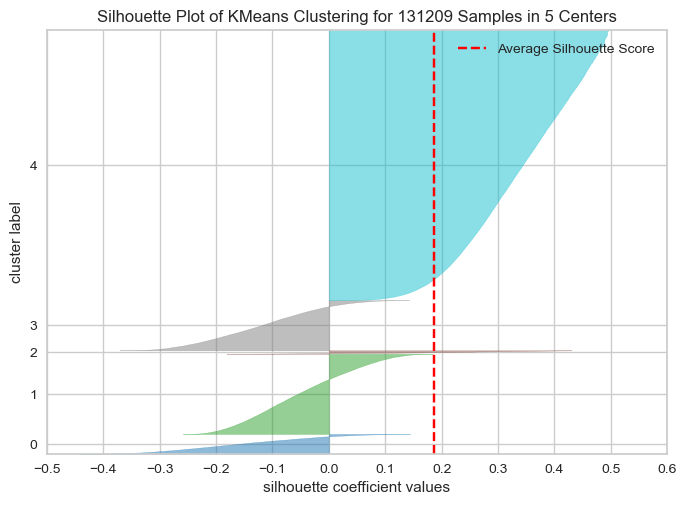

Average Silhouette Score: 0.18619968342918725


In [24]:
#silhouette curve
sv = silhouette_visualizer(KMeans(n_clusters=5, random_state=1), pca_data, colors='tab10');
print(f'Average Silhouette Score: {sv.silhouette_score_}')

The Silhouette Score ranges from -1 to 1, where a score of 1 indicates that the data point is very similar to other data points in its cluster and very dissimilar to data points in other clusters. A score of -1 indicates the opposite, where a data point is dissimilar to data points in its own cluster and very similar to data points in other clusters. 

Silhouette Score is 0.18, it means that clusters are located close to each other.

In [25]:
# lets fit a K-Means model

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

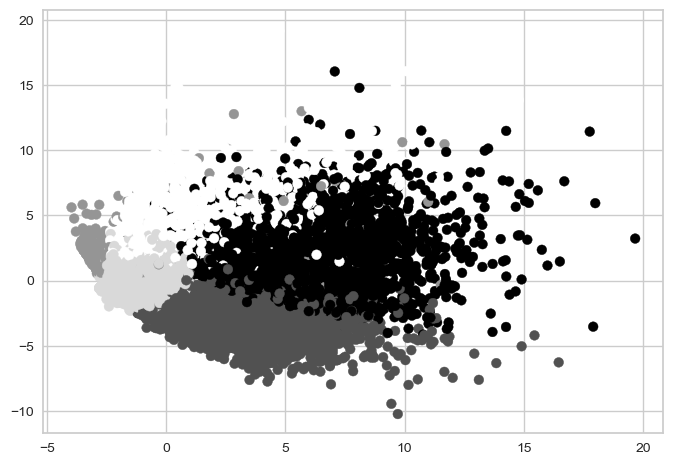

In [26]:
# plot results

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
plt.show()

Lets copy existing table and add column with cluster number.

In [27]:
#Make a copy of the original dataframe
my_product_basket = my_product_basket.copy()

#Append the cluster labels as new columns
my_product_basket['kmeans'] = kmeans.labels_

In [28]:
my_product_basket.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,kmeans
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,2,0,0,0,...,0,0,1,0,0,0,1,0,1,4


Group by clusters and calculate the number of products in each aisles were bought by every cluster..

In [40]:
kmean_df = my_product_basket.groupby(['kmeans']).sum()
kmean_df

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
kmeans,,,,,,,,,,,,,,,,,,,,,
0,608,300,45,127,680,44,840,97,188,61,...,652,668,102,423,53,784,187,2401,33,2231
1,243,2121,116,90,4549,943,5306,523,55,562,...,4861,4791,1322,2217,845,508,980,21077,257,21743
2,24,39,1,0,35,11,62,7,2,1045,...,43,54,4,71,5,18,6,326,693,212
3,62,3272,65,41,3222,155,4669,199,21,50,...,2950,1672,2961,3176,78,113,426,6047,42,14238
4,130,1275,79,70,4712,348,2211,268,21,121,...,3596,2191,734,2466,482,198,370,6766,63,16816


Lets identify the most popular product aisles for each cluster and plot them.

#### Cluster 1

This cluster demonstrates a clear tendency among customers to purchase paper goods, cleaning products, and laundry items. Despite their limited order volume, customers in this cluster consistently prioritize these household essentials.

Column 'fresh fruits': 4459
Column 'paper goods': 4320
Column 'fresh vegetables': 3870
Column 'cleaning products': 3182
Column 'packaged vegetables fruits': 2429
Column 'water seltzer sparkling water': 2401
Column 'laundry': 2270
Column 'yogurt': 2231
Column 'packaged cheese': 1827
Column 'oral hygiene': 1601
Column 'body lotions soap': 1598
Column 'chips pretzels': 1514
Column 'dish detergents': 1489
Column 'soft drinks': 1441
Column 'milk': 1338
Column 'ice cream ice': 1314
Column 'refrigerated': 1222
Column 'frozen meals': 1179
Column 'cereal': 1161
Column 'crackers': 1150


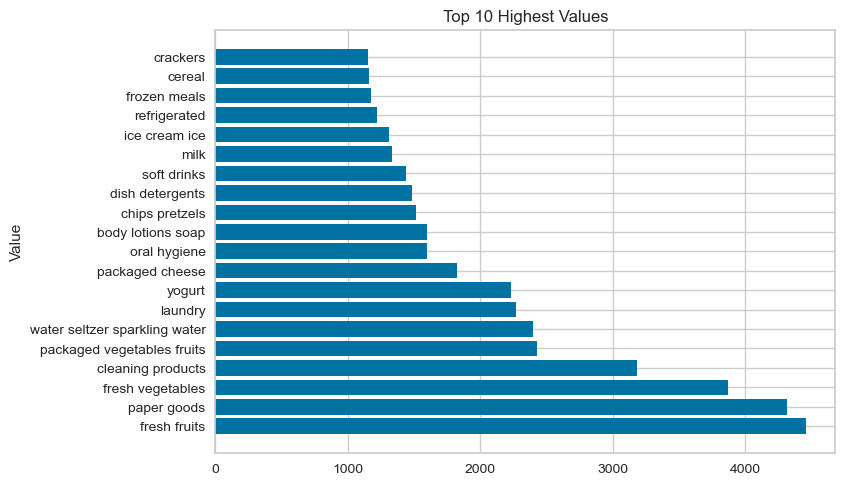

In [79]:
####### 1 #########
# filtr a cluster
cl1 = kmean_df[0:1]

# find the top 10 highest values in the dataframe
top10_cl1 = cl1.stack().nlargest(20)

# print the column name and the corresponding value for each of the top 10 highest values
for index in top10_cl1.index:
    column_name = index[1]
    value = top10_cl1.loc[index]
    print("Column '{}': {}".format(column_name, value))

fig, ax = plt.subplots()
ax.barh(top10_cl1.index.get_level_values(1), top10_cl1.values)
ax.set_ylabel('Value')
ax.set_title('Top 10 Highest Values')
plt.show()

#### Cluster 2

Of the three clusters that exhibit a propensity for food purchases, this particular cluster stands out for their frequent purchase of processed foods and comparatively unhealthy product selection. Their shopping basket includes a higher proportion of items that are typically considered less nutritious.

Column 'fresh fruits': 62498
Column 'fresh vegetables': 46127
Column 'packaged vegetables fruits': 28456
Column 'yogurt': 21743
Column 'water seltzer sparkling water': 21077
Column 'milk': 15564
Column 'packaged cheese': 13681
Column 'chips pretzels': 12244
Column 'soy lactosefree': 11198
Column 'ice cream ice': 11071
Column 'refrigerated': 10717
Column 'packaged produce': 10336
Column 'soft drinks': 9270
Column 'bread': 9178
Column 'eggs': 7555
Column 'frozen produce': 7523
Column 'frozen meals': 7486
Column 'energy granola bars': 7221
Column 'crackers': 6969
Column 'juice nectars': 6372


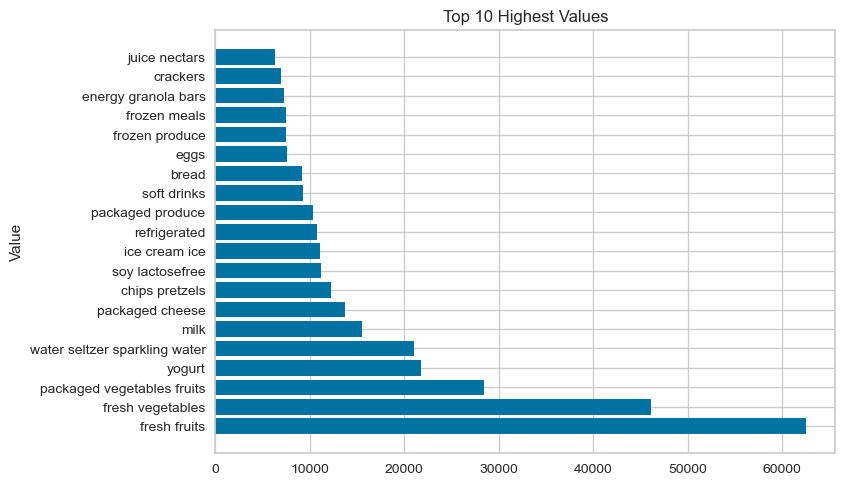

In [80]:
####### 2 #########
# filtr a cluster
cl2 = kmean_df[1:2]

# find the top 10 highest values in the dataframe
top10_cl2 = cl2.stack().nlargest(20)

# print the column name and the corresponding value for each of the top 10 highest values
for index in top10_cl2.index:
    column_name = index[1]
    value = top10_cl2.loc[index]
    print("Column '{}': {}".format(column_name, value))

fig, ax = plt.subplots()
ax.barh(top10_cl2.index.get_level_values(1), top10_cl2.values)
ax.set_ylabel('Value')
ax.set_title('Top 10 Highest Values')
plt.show()

#### Cluster 3

Cluster 3 is characterized by a preference for alcohol and party-related items, including beer and coolers

Column 'beers coolers': 1045
Column 'red wines': 898
Column 'white wines': 693
Column 'fresh vegetables': 523
Column 'spirits': 488
Column 'fresh fruits': 477
Column 'packaged vegetables fruits': 329
Column 'water seltzer sparkling water': 326
Column 'chips pretzels': 324
Column 'specialty wines champagnes': 282
Column 'soft drinks': 259
Column 'packaged cheese': 250
Column 'yogurt': 212
Column 'milk': 172
Column 'paper goods': 172
Column 'crackers': 170
Column 'bread': 167
Column 'ice cream ice': 150
Column 'refrigerated': 149
Column 'frozen meals': 131


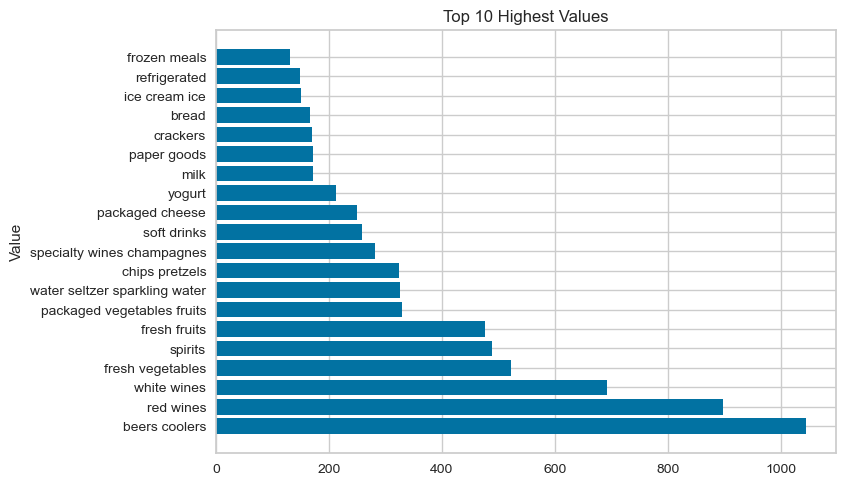

In [81]:
####### 3 #########
# filtr a cluster
cl3 = kmean_df[2:3]

# find the top 10 highest values in the dataframe
top10_cl3 = cl3.stack().nlargest(20)

# print the column name and the corresponding value for each of the top 10 highest values
for index in top10_cl3.index:
    column_name = index[1]
    value = top10_cl3.loc[index]
    print("Column '{}': {}".format(column_name, value))
    
fig, ax = plt.subplots()
ax.barh(top10_cl3.index.get_level_values(1), top10_cl3.values)
ax.set_ylabel('Value')
ax.set_title('Top 10 Highest Values')
plt.show()

#### Cluster 4

Cluster 4 stands out for their large product basket and frequent purchase of healthy products. I can assume that this cluster is represented by families with kids.

Column 'fresh vegetables': 79587
Column 'fresh fruits': 54204
Column 'packaged vegetables fruits': 31819
Column 'yogurt': 14238
Column 'packaged cheese': 12588
Column 'fresh herbs': 11298
Column 'frozen produce': 9284
Column 'soy lactosefree': 9135
Column 'canned jarred vegetables': 7778
Column 'milk': 7421
Column 'eggs': 6988
Column 'canned meals beans': 6460
Column 'soup broth bouillon': 6109
Column 'water seltzer sparkling water': 6047
Column 'bread': 5735
Column 'spices seasonings': 5398
Column 'chips pretzels': 4917
Column 'refrigerated': 4845
Column 'oils vinegars': 4765
Column 'dry pasta': 4671


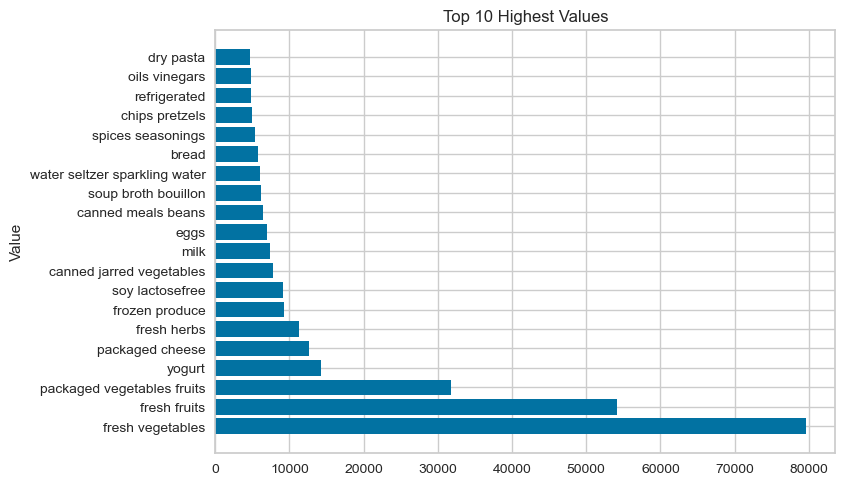

In [82]:
####### 4 #########
# filtr a cluster
cl4 = kmean_df[3:4]

# find the top 10 highest values in the dataframe
top10_cl4 = cl4.stack().nlargest(20)

# print the column name and the corresponding value for each of the top 10 highest values
for index in top10_cl4.index:
    column_name = index[1]
    value = top10_cl4.loc[index]
    print("Column '{}': {}".format(column_name, value))
    
fig, ax = plt.subplots()
ax.barh(top10_cl4.index.get_level_values(1), top10_cl4.values)
ax.set_ylabel('Value')
ax.set_title('Top 10 Highest Values')
plt.show()

#### Cluster 5

Cluster 5 purchases fewer food items compared to other food-buying clusters. Instead, customers in this cluster demonstrate a preference for prepared foods that enable quick and convenient meal preparation.I can assume that this cluster is represented by single persons and hard-workers.


Column 'fresh fruits': 28835
Column 'fresh vegetables': 20502
Column 'yogurt': 16816
Column 'packaged vegetables fruits': 15460
Column 'packaged cheese': 13353
Column 'chips pretzels': 12270
Column 'crackers': 8309
Column 'milk': 8149
Column 'bread': 7418
Column 'frozen meals': 7269
Column 'water seltzer sparkling water': 6766
Column 'energy granola bars': 6513
Column 'ice cream ice': 6466
Column 'lunch meat': 6427
Column 'cereal': 6379
Column 'refrigerated': 6295
Column 'soy lactosefree': 4873
Column 'frozen produce': 4862
Column 'frozen breakfast': 4799
Column 'instant foods': 4779


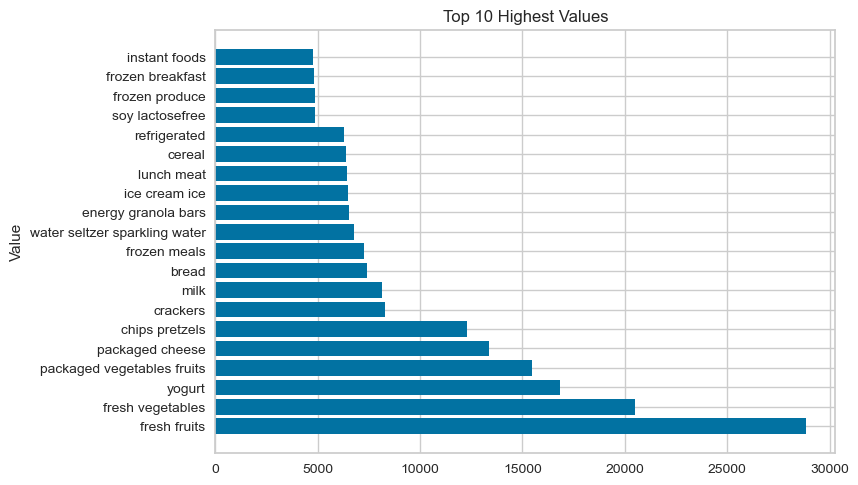

In [83]:
####### 5 #########
# filtr a cluster
cl5 = kmean_df[4:5]

# find the top 10 highest values in the dataframe
top10_cl5 = cl5.stack().nlargest(20)

# print the column name and the corresponding value for each of the top 10 highest values
for index in top10_cl5.index:
    column_name = index[1]
    value = top10_cl5.loc[index]
    print("Column '{}': {}".format(column_name, value))
    
fig, ax = plt.subplots()
ax.barh(top10_cl5.index.get_level_values(1), top10_cl5.values)
ax.set_ylabel('Value')
ax.set_title('Top 10 Highest Values')
plt.show()

To conclude, I employed the K-Means clustering model to classify customers into five distinct clusters. Despite a low silhouette score suggesting a degree of proximity between the clusters, I was able to identify clear patterns in customer behavior that can inform future product recommendations.